# Computer Vision with Transformers

Dans ce notebook, nous allons utiliser la library transformers de Hugging Face pour traîter des images. Pour éviter de surchager le notebook, certaines fonctions se trouvent dans utils/util.py.

## Zero-Shot Object Detection

La détection d'objets dans une image est une tâche importante de vision par ordinateur. Les modèles zero-shot sont particuièrement versatile pour cette tâche car ils peuvent détecter n'importe quel objet dans une image sans avoir besoin d'un "fine-tuning". Il suffit de donner une image entrée ainsi qu'un prompt textuel qui spécifie les classes que l'on veut détecter. 

### Implémentation

Nous avons choisi le modèle [OWL-ViT](https://arxiv.org/pdf/2205.06230) de google (google/owlvit-base-patch32) pour cette tâche car c'est un modèle relativement petit et il pourra tourner sur la plupart des ordinateurs.   
Utilisons le pipeline de Hugging Face : 

In [1]:
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

zeroshot = pipeline("zero-shot-object-detection", model="google/owlvit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Regardons à quoi ressemble notre image.

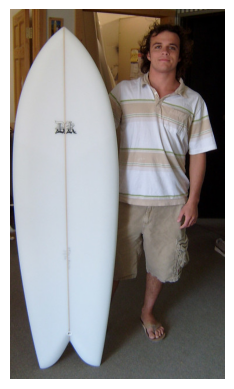

In [119]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

Utilisons le modèle et dessinons les box prédites.

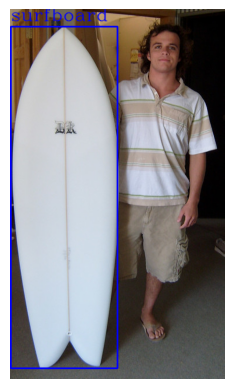

In [120]:
from utils.util import draw_box

text_prompt = "surfboard" # Vous pouvez changer la classe pour détecter autre chose "person" ou "surfboard"
output = zeroshot(image,candidate_labels = [text_prompt])
cv_image=draw_box(image,output)

plt.imshow(cv_image)
plt.axis('off') 
plt.show()

Vous savez maintenant comment implémenter un détecteur d'objet zero-shot en quelques lignes de code. 

## Image Captionning 

La tâche d'image captionning consiste à créer une description d'une image. Le modèle prend en entrée une image et va créer ou compléter une description.

### Implémentation

De la même manière, on utilise le pipeline de Hugging Face pour charger notre model. Ici, nous utilisons le modèle [BLIP](https://arxiv.org/pdf/2201.12086) de salesforce (Salesforce/blip-image-captioning-base).

In [121]:
captionner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")


On va utiliser la même image pour générer une description.

In [122]:
result=captionner(image)
print(result[0]['generated_text'])

a man holding a surfboard in a room


Nous avons généré le texte "un homme qui tient une planche de surf dans une pièce" ce qui est parfaitement exact.   
Vous savez maintenant générer des descriptions d'images. Cela peut être très utile pour générer automatiquement des datasets par exemple. 

## Zero-Shot Image Classification

En plus du zero-shot object detection, on peut aussi faire du zero-shot image classification. Le principe de fonctionnement est un peu le même sauf que cette fois, on va saisir au minimum deux phrases et le modèle va nous renvoyer la probabilité que l'image correspond à une phrase plutôt qu'une autre.

### Implémentation

Utilisons une photo de mon chat pour déterminer sa race : 

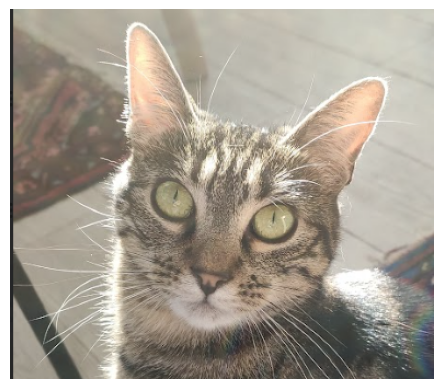

In [123]:
image=Image.open("images/tigrou.png") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

On va essayer de voir si le modèle est capable de déterminer si il s'agit d'un Maine Coon ou d'un chat européen.

Nous utilisons le modèle [CLIP](https://openai.com/index/clip/) de OpenAI (openai/clip-vit-base-patch32). Pour changer, utilisons d'autres fonctions de la library Hugging Face à la place du pipeline.

In [125]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32")


/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [133]:
labels = ["a photo of a european shorthair", "a photo of maine coon"]
inputs = processor(text=labels,images=image,return_tensors="pt",padding=True)
outputs = model(**inputs)
# Transformation des outputs pour obtenir des probabilités

print("Probabilité de a photo of a european shorthair : ",outputs.logits_per_image.softmax(dim=1)[0][0].item())
print("Probabilité de a photo of maine coon : ",outputs.logits_per_image.softmax(dim=1)[0][1].item())

Probabilité de a photo of a european shorthair :  0.9104425311088562
Probabilité de a photo of maine coon :  0.08955750614404678


Le modèle est plutôt confiant sur le fait qu'il s'agit d'un chat européen et comme vous l'avez sans doute deviné, il a raison. 

## Image Segmentation

Pour cet exemple, nous allons faire de la segmentation d'image à partir du modèle [SAM](https://segment-anything.com/) de meta qui permet de segmenter n'importe quel objet.

### Implémentation

In [2]:
sam = pipeline("mask-generation","Zigeng/SlimSAM-uniform-77")

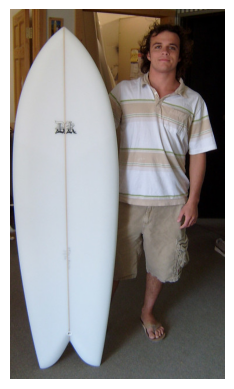

In [3]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [8]:
# ATTENTION : le traitement peut prendre plusieurs minutes
output=sam(image, points_per_batch=32)

In [5]:
masks=output["masks"]

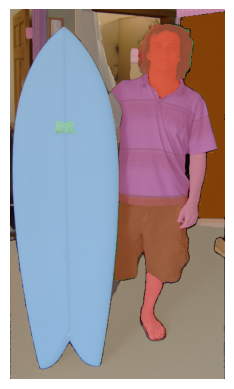

In [7]:
from utils.util import draw_masks
image_np=draw_masks(image,masks)

plt.imshow(image_np)
plt.axis('off') 
plt.show()

Comme vous le voyez, on a segmenté l'ensemble des objets de l'image. Par contre le temps de traitement était vraiment important...   
Pour avoir un temps d'inférence plus raisonnable, utilisons un prompt de coordonnées d'un point de l'image, cela permet de spécifier le traitement et d'avoir un résultat plus rapidement.   
Nous ne pouvons pas utiliser le pipeline pour cette tâche.

In [9]:
from transformers import SamModel, SamProcessor

In [10]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

Créeons notre prompt de coordonnées et visualisons le point : 

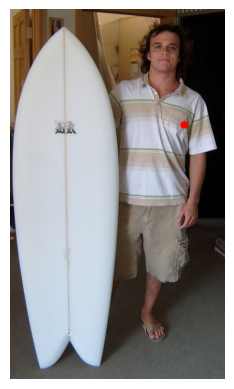

In [41]:
input_points = [[[300, 200]]]
image_np= np.array(image)
cv2.circle(image_np,input_points[0][0],radius=3,color=(255,0,0),thickness=5)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [44]:
inputs = processor(image,input_points=input_points,return_tensors="pt")
outputs = model(**inputs)
predicted_masks = processor.image_processor.post_process_masks(
  outputs.pred_masks,
  inputs["original_sizes"],
  inputs["reshaped_input_sizes"]
)

Le traitement est beaucoup plus rapide !!   
SAM produit 3 masques par défauts, chaque masque est une possibilité de masking de l'image. Vous pouvez changer la valeur **mask_number** pour visualiser les différents masques.  

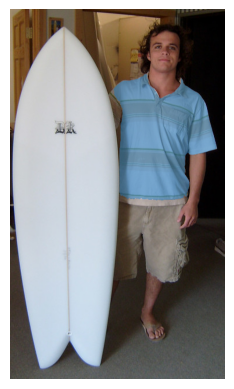

In [46]:
mask_number=2 # 0,1 or 2
mask=predicted_masks[0][:, mask_number] 
image_np=draw_masks(image,mask)
plt.imshow(image_np)
plt.axis('off') 
plt.show()

Dans cet exemple, on voit que les 3 masques sont pertinents : le premier segmente la personne en entier, le second segmente les vetements et le troisième segmente uniquement le t-shirt.   
Vous pouvez essayer de changer les coordonnées du point et de visualiser les masques générés. 

## Estimation de la profondeur 

Une tâche importante de la vision par ordinateur est l'estimation de la profondeur. C'est très utile pour des cas d'usage comme la voiture autonome où l'on cherche à estimer la distance par rapport au véhicule devant nous. Pour les colis dans l'industrie, c'est aussi quelque chose de très intéressant permettant d'organiser les objets dans un colis en fonction de l'espace restant.   
Pour cet exemple, nous utilisons le modèle [DPT](https://arxiv.org/pdf/2103.13413) (Intel/dpt-hybrid-midas) qui prend une image en entrée et nous renvoie une carte de profondeur.

### Implémentation

In [47]:
depth_estimator = pipeline(task="depth-estimation",model="Intel/dpt-hybrid-midas")

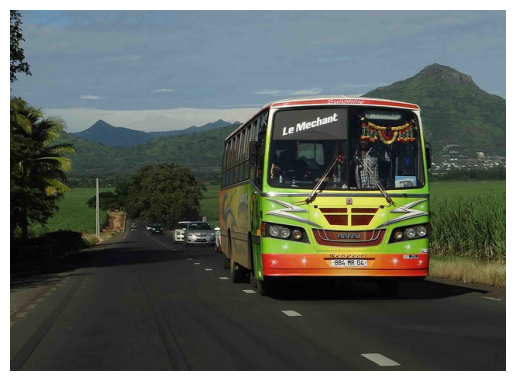

In [48]:
image=Image.open("images/coco2.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [57]:
outputs = depth_estimator(image)
outputs["predicted_depth"].shape

torch.Size([1, 384, 384])

On utilise pytorch pour faire correspondre la dimension de la carte de profondeur prédite à celle de notre image de base puis on génere une image de notre carte de profondeur.

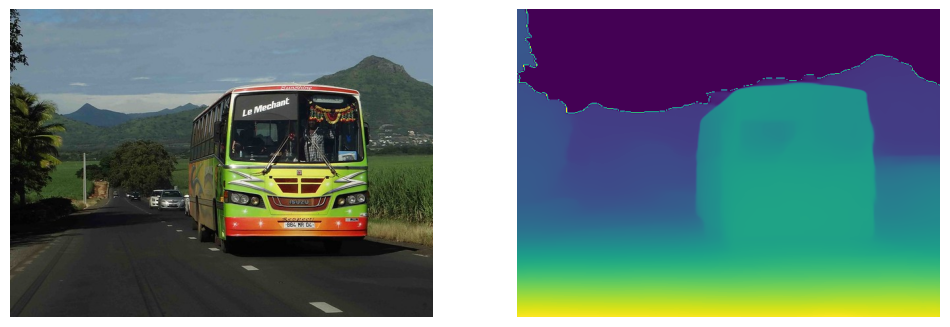

In [60]:
import torch 
prediction = torch.nn.functional.interpolate(outputs["predicted_depth"].unsqueeze(1),size=image.size[::-1],
                                             mode="bicubic",align_corners=False)
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
ax1.imshow(image)
ax1.axis('off')  
ax2.imshow(depth)
ax2.axis('off')  
plt.show()

Sur la carte de profondeur, les couleurs vives representent les objects les plus proches. On a bien la route proche de couleur très vive et le bus de couleur assez vive. La carte de profondeur est donc précise.